This notebook uses data files that are not provided in this data supplement. Links to data sources are provided throughout, and datasets used for further analysis are available in the Data directory.

## Jupyter (Python) notebook to screen USGS basins based on a variety of selection criteria
based on code written by David Dralle


In [1]:
# Import required libraries for the analyses

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import georasters as gr
from scipy import stats
import warnings
warnings.filterwarnings("ignore")


/Users/Dana/miniconda3/lib/python3.8/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/Users/Dana/miniconda3/lib/python3.8/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [38]:
# https://water.usgs.gov/GIS/metadata/usgswrd/XML/streamgagebasins.xml
# get shapefile of gage locations

# gages = gpd.read_file('../../USGS_Streamgages-NHD_Locations_Shape/USGS_Streamgages-NHD_Locations.shp')

In [48]:
# # grab basin outlines for each gage

# for i in range(18):
#     i += 1
#     i = str(i)
#     if len(i)<2:
#         i = '0'+i
#     huc_outline = gpd.read_file('/Volumes/Seagate One Touch HDD Media/USGS_basin_outlines/basins'+i+'/basins'+i+'.shp')
#     if i=='01':
#         gages = huc_outline
#     else:
#         gages = pd.concat([huc_outline,gages])


In [49]:
# gpd.read_file('../data/basins/basins18_utm.shp')

In [50]:
# gage_n = gpd.read_file('../data/USGS_gages/USGS_Streamgages-NHD_Locations.shp')
# gage_n = gage_n[gage_n.STATION_NM.str.endswith('CA')]
# gages = gages[gages.SITE_NO.isin(gage_n.SITE_NO.values)]
# gages.to_file('../../usgs_basins_california.shp')

In [134]:
# import shapefil with USGS gages in California including basin shapes
gages = gpd.read_file('../../usgs_basins_california.shp')

<AxesSubplot:>

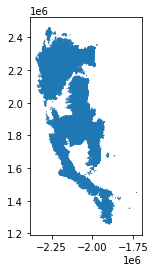

In [52]:
# plot all gages to see where they are
gages.plot()

In [135]:
#get the stream gage names
gage_names = gpd.read_file('../data/USGS_gages/USGS_Streamgages-NHD_Locations.shp')
gage_names = gage_names[gage_names.STATION_NM.str.endswith('CA')]

In [136]:
#Create a dictionary that maps the USGS gage ID number to the station name
id_name = dict(zip(gage_names.SITE_NO,gage_names.STATION_NM))

In [137]:
#Read in information about dams from the GAGES II database, find sites with 0 dams
dam_data = pd.read_csv('../data/basinchar_and_report_sept_2011/spreadsheets-in-csv-format/conterm_hydromod_dams.txt')
no_dams = dam_data[dam_data['NDAMS_2009']==0]
no_dams['SITE_NO'] = np.where(np.array([len(no_dams.STAID.astype('str').values[i])
                  for i in range(len(no_dams))])<8,
        [ '0'+no_dams.STAID.astype('str').values[i]
        for i in range(len(no_dams))], no_dams.STAID.astype('str'))
gage_names = gage_names.merge(no_dams[['SITE_NO']],
                             left_on='SITE_NO',right_on='SITE_NO',
                             how='inner')

In [138]:
# print number of remaining gages
len(gage_names)

281

In [139]:
# get a CA outline map for reference when seeing where gages are
us_outline = gpd.read_file('/Users/Dana/Desktop/Jupyter/WISC/NaturalCommunity/US_state_outline/cb_2018_us_state_500k.shp').to_crs(epsg=4326)
ca_outline = us_outline[us_outline.NAME=='California']

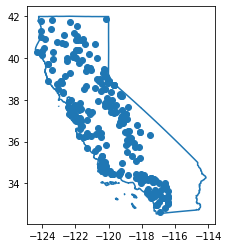

In [140]:
# plot remaining gages
ca_outline.boundary.plot()
plt.scatter(gage_names.LON_SITE,gage_names.LAT_SITE)

In [143]:
#Read in information about climate from the GAGES II database, find sites with > 20 percent precip as snow

climate_data = pd.read_csv('../data/basinchar_and_report_sept_2011/spreadsheets-in-csv-format/conterm_climate.txt')
snow_dominated = climate_data[climate_data['SNOW_PCT_PRECIP']>20]
snow_dominated['SITE_NO'] = np.where(np.array([len(snow_dominated.STAID.astype('str').values[i])
                  for i in range(len(snow_dominated))])<8,
        [ '0'+snow_dominated.STAID.astype('str').values[i]
        for i in range(len(snow_dominated))], snow_dominated.STAID.astype('str'))
gage_names = gage_names.merge(snow_dominated[['SITE_NO']],
                             left_on='SITE_NO', right_on='SITE_NO',
                             how='inner')

In [144]:
# print number of remaining gages
len(gage_names)

95

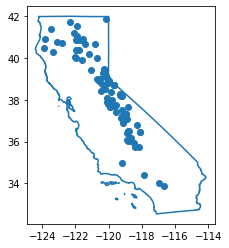

In [145]:
# plot locations of remaining gages
ca_outline.boundary.plot()
plt.scatter(gage_names.LON_SITE,gage_names.LAT_SITE)

In [146]:
# confine to gages with delineated watershed boundaries
gage_names = gage_names[gage_names.SITE_NO.isin(gages.SITE_NO)]
# print number of remaining gages
len(gage_names)

82

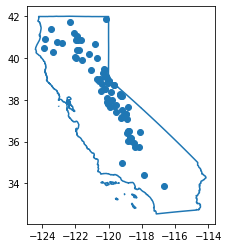

In [147]:
# plot locations of remaining gages
ca_outline.boundary.plot()
plt.scatter(gage_names.LON_SITE,gage_names.LAT_SITE)

In [148]:
# Read in the National Land Cover Database (NLCD)
#source: https://www.mrlc.gov/nlcd2011.php
#original raster file has been converted to UTM and clipped to California
landcover = gr.from_file('../data/landcover/cal_landcover_utm10N.tif')


In [149]:
#determine the percentage of 'developed' landcover in each polygon
#create empty list
land_cover_developed_pct = []
missing_gages=[]
#loop through study gages, 
i = 0
for gage in list(gage_names.SITE_NO):
#     print (i)
    gage = str(gage)
    #get the basin polygon
    basin_polygon = gages[gages.SITE_NO==gage].geometry
    #clip the landcover raster to this polygon
    r_basin = landcover.clip(basin_polygon)[0]
    #convert all the pixel values of this raster to one long array
    pixel_values =  r_basin.raster.data.flatten().astype(int)
    #determine the percent developed based on the NLCD legend, https://www.mrlc.gov/nlcd11_leg.php
    pct_developed = 100*(np.count_nonzero(pixel_values == 22)+
                         np.count_nonzero(pixel_values == 23)+
                         np.count_nonzero(pixel_values == 24))/np.count_nonzero(pixel_values)
    land_cover_developed_pct.append(pct_developed)
    i+= 1
  
            
gage_names['developed_pct'] = land_cover_developed_pct

In [150]:
# print number of remaining gages
gage_names = gage_names[gage_names.developed_pct<5]
len(gage_names)

82

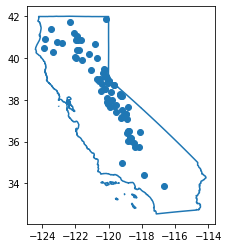

In [151]:
# plot locations of remaining gages
ca_outline.boundary.plot()
plt.scatter(gage_names.LON_SITE,gage_names.LAT_SITE)

In [152]:

#Perform a similar operation, this time with 'cultivated' lands

land_cover_cultivated_pct = []
for gage in list(gage_names.SITE_NO.values):
    gage = str(gage)
    pct_cultivated = 0
    basin_polygon = gages[gages.SITE_NO==gage].geometry
    r_basin = landcover.clip(basin_polygon)[0]
    pixel_values =  r_basin.raster.data.flatten().astype(int)

    pct_cultivated = 100*(float(np.count_nonzero(pixel_values == 82))/np.count_nonzero(pixel_values))
    land_cover_cultivated_pct.append(pct_cultivated)
gage_names['cultivated_pct'] = land_cover_cultivated_pct

In [153]:
# print number of remaining gages
gage_names = gage_names[gage_names.cultivated_pct<5]
len(gage_names)

82

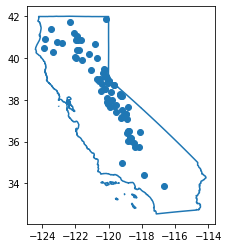

In [154]:
# map locations of remaining gages
ca_outline.boundary.plot()
plt.scatter(gage_names.LON_SITE,gage_names.LAT_SITE)

In [155]:
# find burned areas 1990-2020 and limit to basins that burned less than 20%
# data through 2020 is actually from: https://frap.fire.ca.gov/mapping/gis-data/

import fiona 
import geopandas as gpd

gdb_file = '../data/fire20_1.gdb'

# Get all the layers from the .gdb file 
layers = fiona.listlayers(gdb_file)

for layer in layers[:1]:
    fire_data = gpd.read_file(gdb_file,layer=layer).to_crs(epsg=4326)

fire_data = fire_data[~(fire_data.YEAR_.isin(['',None]))]
fire_data['YEAR_'] = fire_data['YEAR_'].astype('int')
fire_data_recent = fire_data[fire_data['YEAR_']>1990]

# get an outline of all burned area 1990-2020
from shapely.ops import cascaded_union
polygons = fire_data_recent.geometry
boundary = gpd.GeoSeries(cascaded_union(polygons))

In [156]:
# find overlap between burn areas and basins
from shapely.geometry import Polygon
gages1 = gages.to_crs(epsg=4326)

burn_fraction = []
for gage in list(gage_names.SITE_NO.values):
    gage = str(gage)
    
    basin_polygon = gages1[gages1.SITE_NO==gage].geometry.values[0]
    overlap_area = 0
    for poly in boundary:
        overlap = poly.intersection(basin_polygon).area
        overlap_area += overlap
    overlap_fraction = overlap_area/basin_polygon.area
    burn_fraction.append(overlap_fraction)

In [172]:
gage_names['burn_fraction'] = burn_fraction
gage_names[gage_names.burn_fraction>0]

# don't keep sites with >20% burned area

gage_names = gage_names[gage_names.burn_fraction<.35]

In [173]:
# gage_names = gage_names[~(gage_names.SITE_NO.astype(int).isin(burned_sites))]
# print number of remaining gages
len(gage_names)

60

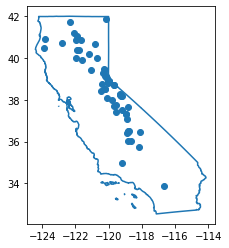

In [174]:
# map locations of remaining gages
ca_outline.boundary.plot()
plt.scatter(gage_names.LON_SITE,gage_names.LAT_SITE)

In [175]:
# Perform a similar analysis where the basins have been intersected with a geospatial logging layer
#this lists locations where a timber harvest plan of 'clearcut' or 'commercial thin completed' has been achieved

#The original data source is: ftp://ftp.fire.ca.gov/forest/Statewide_Timber_Harvest/
# these layers were reduced with the 'tabulate intersection' tool in ArcGIS, http://pro.arcgis.com/en/pro-app/tool-reference/analysis/tabulate-intersection.htm

logging = pd.read_csv('../data/Cal_USGS_Basins_TabulatedIntersection_THP_Clearcut_or_CommercialThin_Completed.csv')

logging_threshold_size_fraction = 20 #%


site_group = logging.groupby(['SITE_NO'])

total_fraction_logged = site_group['PERCENTAGE'].agg('sum').reset_index()

recent_large_fires = total_fraction_logged[total_fraction_logged.PERCENTAGE>logging_threshold_size_fraction]

logged_sites = np.unique(recent_large_fires['SITE_NO'])
# study_gages = set(study_gages)-set(logged_sites)


In [177]:
# print number of remaining gages
gage_names = gage_names[~(gage_names.SITE_NO.astype(int).isin(logged_sites))]
len(gage_names)

60

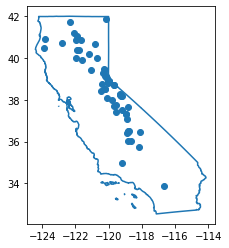

In [178]:
# map locations of remaining gages
ca_outline.boundary.plot()
plt.scatter(gage_names.LON_SITE,gage_names.LAT_SITE)

In [179]:
study_gages = gage_names.SITE_NO.values

In [182]:
# get data on how continuous record is 2011-2021
# only keep gages with 10 years of data and include the year 2021

import hydrofunctions as hf 

def check_continuous(site):
    try:
        flow_data = hf.NWIS(site, 'dv', start_date = '2001-10-01', 
                           end_date = '2021-10-01').df('00060')
    except:
        return False
    record_days = len(flow_data)
    start_date = pd.to_datetime(flow_data.index.values[0])
    end_date = pd.to_datetime(flow_data.index.values[-1])
    years = list(range(2001,2022))
    data_years = []
    for yr in years:
        flow_yr = flow_data.loc[str(yr)+'-04-01':str(yr)+'-08-01']
        if len(flow_yr)>=110:
            data_years.append(yr)
#     print(data_years)
    if (len(data_years)>=10) & ((2021 in data_years) ):
#     if (record_days >= 10*365*0.98) & (end_date>pd.to_datetime('2021-07-01')):
        return True
    else:
        return False

continuous_record = []
for gage in study_gages:
    print(gage)
    continuous_record.append(check_continuous(gage))

10336580
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336580&startDT=2001-10-01&endDT=2021-10-01
10336600
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336600&startDT=2001-10-01&endDT=2021-10-01
10336770
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336770&startDT=2001-10-01&endDT=2021-10-01
10336775
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336775&startDT=2001-10-01&endDT=2021-10-01
10336780
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336780&startDT=2001-10-01&endDT=2021-10-01
10336626
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336626&startDT=2001-10-01&endDT=2021-10-01
10336645
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336645&startDT=2001-10-01&endDT=2021-10-01
10336660
Requested data from https

In [183]:
# print number of remaining gages
gage_names['continuous'] = continuous_record
gage_names1 = gage_names[gage_names.continuous==True]
len(gage_names1)

18

In [185]:
gage_names = gage_names1

<AxesSubplot:>

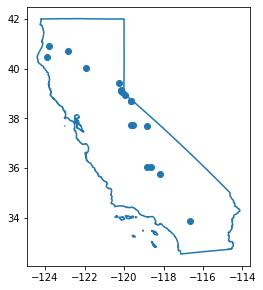

In [186]:
# map locations of remaining gages
us_outline = gpd.read_file('/Users/Dana/Desktop/Jupyter/WISC/NaturalCommunity/US_state_outline/cb_2018_us_state_500k.shp').to_crs(epsg=4326)
ca_outline = us_outline[us_outline.NAME=='California']
fig,ax = plt.subplots(1,figsize = (4,9))

ca_outline.to_crs(epsg=4326).boundary.plot(ax = ax)
gage_names.to_crs(epsg=4326).geometry.plot(ax = ax)
# plt.scatter(-119.7,37.7)

In [189]:
# reomve sites not in the sierra
# https://gis.data.ca.gov/datasets/SNC::sierra-nevada-conservancy-boundary-gis-data-for-download/about

sierra = gpd.read_file('../../sierra_outline/SNC_Boundary.shp').to_crs(epsg=4326)

gage_in_sierra_outline = gage_names.sjoin(sierra, how="inner", predicate='intersects')
tahoe_gages = gage_names[(gage_names.LON_SITE>-121)&(gage_names.LAT_SITE<40)&(gage_names.LAT_SITE>34)]
keep_gages = gage_names[(gage_names.FID_SITES.isin(gage_in_sierra_outline.FID_SITES.values)) |
                       (gage_names.FID_SITES.isin(tahoe_gages.FID_SITES.values))]

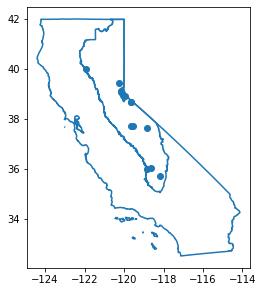

In [190]:
# map final set of gages
fig,ax = plt.subplots(1,figsize = (4,9))

ca_outline.to_crs(epsg=4326).boundary.plot(ax = ax)
sierra.boundary.plot(ax=ax)
# gage_in_sierra_outline.to_crs(epsg=4326).geometry.plot(ax = ax)
# gage_names.to_crs(epsg=4326).geometry.plot(ax=ax)
keep_gages.to_crs(epsg=4326).geometry.plot(ax=ax)
# len(keep_gages),len(gage_names)
# tahoe_gages.to_crs(epsg=4326).geometry.plot(ax=ax)
gage_names = keep_gages

In [191]:
study_gages = gage_names.SITE_NO.values
study_gages

array(['10336780', '10336645', '10336660', '10336676', '10343500',
       '10308783', '103087891', '11383500', '11189500', '11204100',
       '11203580', '11266500', '11264500', '10265150'], dtype=object)

10336780
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336780&startDT=2001-10-01&endDT=2021-10-01
10336645
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336645&startDT=2001-10-01&endDT=2021-10-01
10336660
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336660&startDT=2001-10-01&endDT=2021-10-01
10336676
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336676&startDT=2001-10-01&endDT=2021-10-01
10343500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10343500&startDT=2001-10-01&endDT=2021-10-01
10308783
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10308783&startDT=2001-10-01&endDT=2021-10-01
103087891
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=103087891&startDT=2001-10-01&endDT=2021-10-01
11383500
Requested data from htt

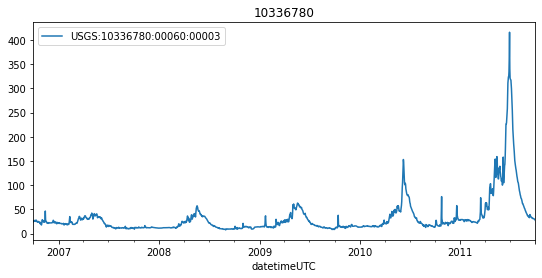

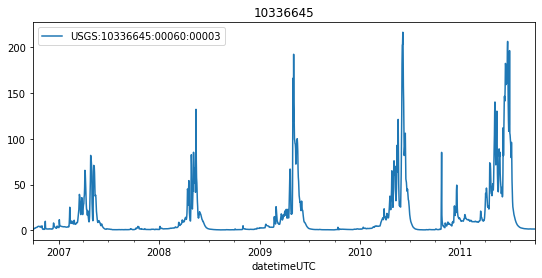

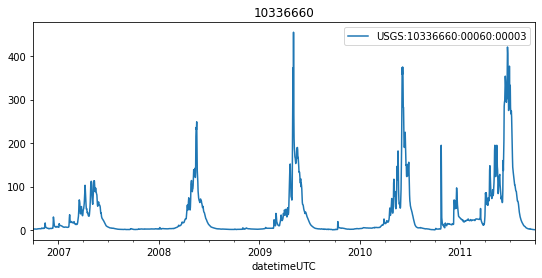

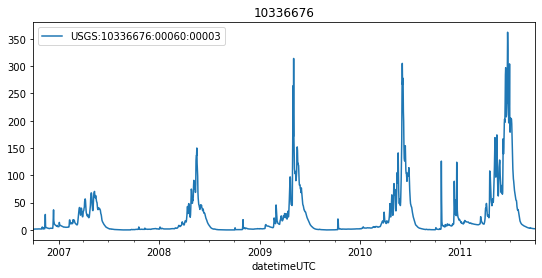

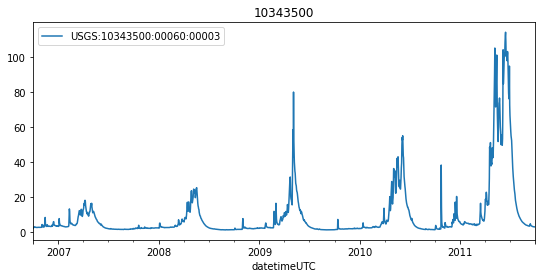

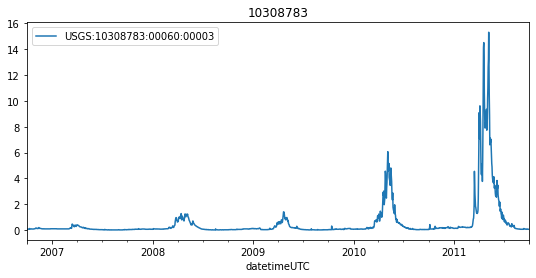

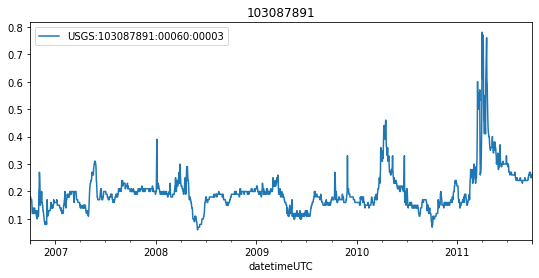

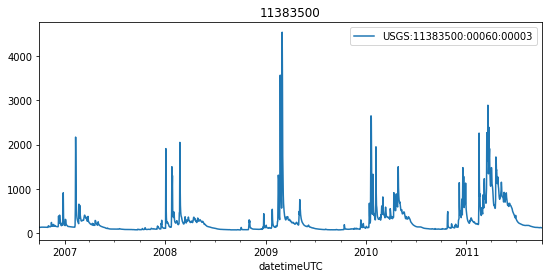

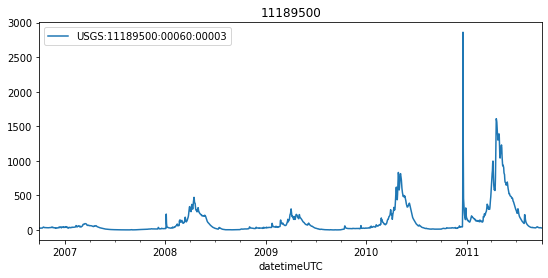

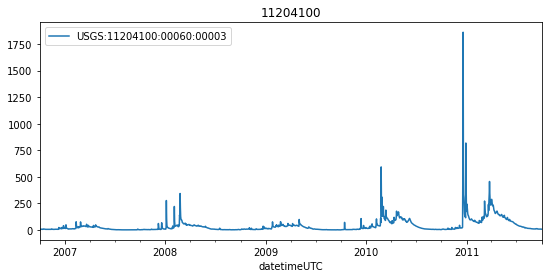

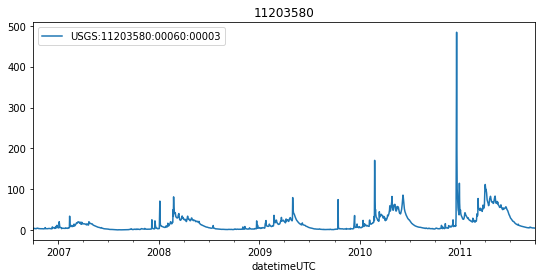

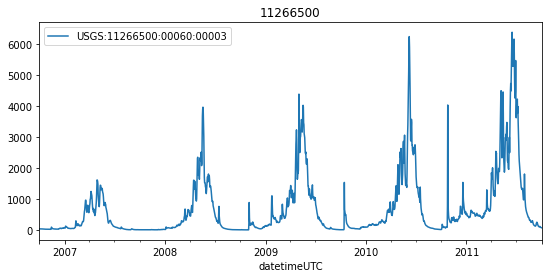

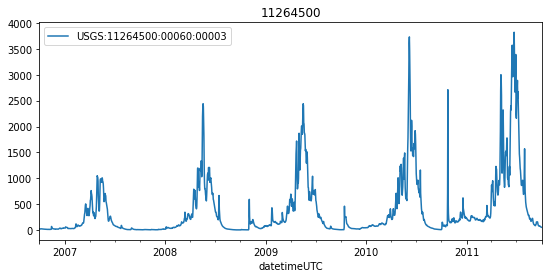

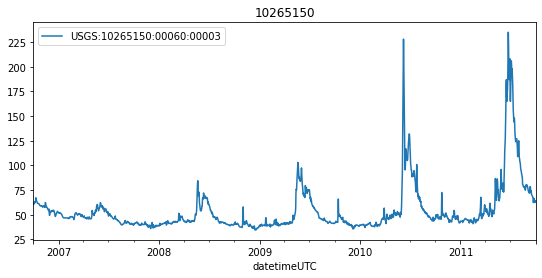

In [192]:
# check that hydrograph looks normal at each site

def check_hydrograph(site):
    try:
        flow_data = hf.NWIS(site, 'dv', start_date = '2001-10-01', 
                           end_date = '2021-10-01').df('00060')
    except:
        return False
    fig,ax = plt.subplots(1,figsize = (9,4))
    s1 = pd.to_datetime('10-1-2006')
    e1 = pd.to_datetime('10-1-2011')
    s2 = pd.to_datetime('10-1-2018')
    e2 = pd.to_datetime('10-1-2020')
    
    flow_data.loc[s1:e1].plot(ax=ax)
    ax.set_title(site)
#     flow_data.loc[s2:e2].plot(ax=ax[1])
    plt.show()



continuous_record = []
for gage in study_gages:
    print(gage)
    check_hydrograph(gage)

In [193]:
bad_gages = ['103087891',]
gage_names = gage_names[~gage_names.SITE_NO.isin(bad_gages)]

<AxesSubplot:>

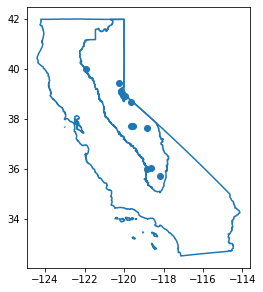

In [194]:
# map final set of gages
fig,ax = plt.subplots(1,figsize = (4,9))

ca_outline.to_crs(epsg=4326).boundary.plot(ax = ax)
sierra.boundary.plot(ax=ax)
gage_names.to_crs(epsg=4326).plot(ax=ax)

In [195]:
# print number of remaining gages
len(gage_names)

13

In [196]:
# save gage info for analysis
gage_names1 = gage_names[['SITE_NO','STATION_NM','LON_SITE',
            'LAT_SITE','geometry']].reset_index().drop(columns='index')
gage_names1.to_file('../../california_site_list.shp')

In [197]:
study_gages = gage_names.SITE_NO.values
gages[gages.SITE_NO.isin(study_gages)].to_file('../../california_site_watershed_boundaries.shp')

In [2]:
# gages[gages.SITE_NO=='11264500'].to_crs(epsg=4326).to_file('11264500.geojson',driver='GeoJSON')

In [259]:
# get data on how continuous record is 2011-2021
import hydrofunctions as hf 

def calc_mean_flow(site):
    flow_data = hf.NWIS(site, 'dv', start_date = '2001-10-01', 
                           end_date = '2021-10-01').df('00060')
    return(np.nanmean(flow_data))

mean_flow = []
for gage in study_gages:
    print(gage)
    mean_flow.append(calc_mean_flow(gage))
    print(mean_flow[-1])

10336780
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336780&startDT=2001-10-01&endDT=2021-10-01
33.47764987681358
10336645
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336645&startDT=2001-10-01&endDT=2021-10-01
15.738004379961675
10336660
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336660&startDT=2001-10-01&endDT=2021-10-01
33.04594579797427
10336676
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336676&startDT=2001-10-01&endDT=2021-10-01
24.774600328497122
10343500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10343500&startDT=2001-10-01&endDT=2021-10-01
9.636424856282508
10308783
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10308783&startDT=2001-10-01&endDT=2021-10-01
0.6138324664659184
11383500
Requested data from https://waterservices.usgs.gov/n

In [273]:
# print out site attributes

gage_names['Area [km^2]'] = gage_names.DA_SQ_MILE * 2.58999
gage_names['Mean Annual Q [m^3/s]'] = np.array(mean_flow) * 0.53802
# gage_names['Gage location'] = gage_names.LON_SITE.astype('str')+', '+gage_names.LAT_SITE.astype('str')
gage_names['Gage location'] = [gage_names.LON_SITE.astype('str').values[i][:8] + ', '+
                              gage_names.LAT_SITE.astype('str').values[i][:7] for i in 
                              range(len(gage_names))]
gage_names['Site name'] = [n[:-3].title() for n in gage_names.STATION_NM]
gage_names['Site number'] = gage_names.SITE_NO.astype('int')

gage_names2 = gage_names.merge(climate_data[['STAID','PPTAVG_SITE','SNOW_PCT_PRECIP']],
                               left_on='Site number',right_on='STAID',how='left')
gage_names2['Mean Annual P [mm]'] = gage_names2.PPTAVG_SITE*10
gage_names2['Snow percent'] = gage_names2.SNOW_PCT_PRECIP
print_site_info = gage_names2[['Site number','Site name','Gage location','Area [km^2]','Mean Annual P [mm]','Snow percent', 'Mean Annual Q [m^3/s]']]
print_site_info.to_latex(index=False,float_format = '%2.0f')
print_site_info

,Site number,Site name,Gage location,Area [km^2],Mean Annual P [mm],Snow percent,Mean Annual Q [m^3/s]
0,10336780,Trout C Nr Tahoe Valley,"-119.972, 38.9199",95.052633,632.8,66.6,18.011645
1,10336645,General C Nr Meeks Bay,"-120.118, 39.0518",19.269526,851.3,57.6,8.467361
2,10336660,Blackwood C Nr Tahoe City,"-120.162, 39.1074",29.007888,865.3,59.2,17.779380
3,10336676,Ward C At Hwy 89 Nr Tahoe Pines,"-120.157, 39.1321",25.122903,871.0,61.2,13.329230
4,10343500,Sagehen C Nr Truckee,"-120.237, 39.4315",27.194895,879.3,65.3,5.184589
5,10308783,Leviathan C Ab Mine Nr Markleeville,"-119.656, 38.7012",10.618959,638.1,60.0,0.330254
6,11383500,Deer C Nr Vina,"-121.948, 40.0140",538.717920,880.8,32.5,161.880556
7,11189500,Sf Kern R Nr Onyx,"-118.173, 35.7374",1372.694700,368.7,35.9,59.627359
8,11204100,Sf Tule R Nr Reservation Bndry Nr Porterville,"-118.813, 36.0241",248.121042,455.9,25.2,19.113666
9,11203580,Sf Tule R Nr Cholollo Campground Nr Porterville,"-118.654, 36.0482",52.058799,824.3,44.5,8.710860


In [70]:
# save basin shapes as geojson to use to get ESI data
basins_geojson = gages[gages.SITE_NO.isin(study_gages)].to_crs(epsg=4326)
for i in range(len(basins_geojson)):
    gageid = basins_geojson.iloc[i].SITE_NO
    if gageid in ['10308783','11481500']:
        basin_geo = basins_geojson.iloc[i:i+1]
        basin_geo['geometry'] = [basin_geo.geometry.iloc[0][-1] for i in range(1)]
        basin_geo.to_file('../../california_sites_'+gageid+'.geojson',driver='GeoJSON')